## Credit Card Churning Classification 
### For IBM Advanced Data Science Capstone - Pat Hornchaiya

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix

from matplotlib import pyplot as plt
%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Loading and Preprocessing

In [ ]:
data = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv")

In [ ]:
# Trim last 2 columns out as they ar not related
data = data[data.columns.tolist()[:-2]]
data['Attrition_Flag'].unique()

In [ ]:
# Convert "Attrition Flag" to 1 (Attried Customer) and 0 (Existing Customer)
data['Is_Churn'] = data['Attrition_Flag'].apply(lambda x: 1 if(x == 'Attrited Customer') else 0)
data.head()

## Data Profiling

In [ ]:
# Data profiling using Pandas Data Profiling package
data.profile_report()

## Correlation Metrix from Pandas Profiling
1. When we take a look at Peason's Correlation of Is_Churn flag (Attrition_Flag), there are some features that show relatively high postitive and negative correlation with Is_Churn flag.
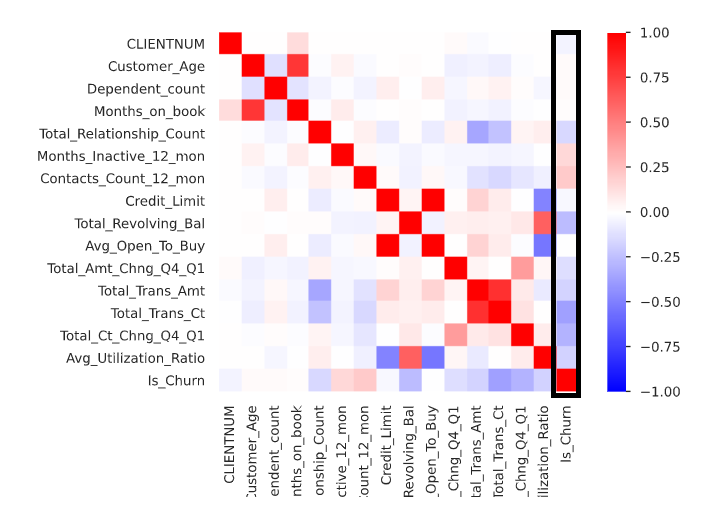

### **Positive Correlation**

-> No. of contacts in the last 12 months - This is pretty surprising but also possible that higher number of contacts means worse user experience

-> No. of inactive months - Higher inactive months can indicates churning behavior

### **Negative Correlation**

-> Total transaction counts - Higher number of transactions = Higher engagement

-> Total transaction counts changes from Q4 to Q1 - Positive/Incresing number of transactions = Less likely to attrited

-> Total revolving balance - Higher balance = Less likely to attrited

-> Total transaction amount and amount changes from Q4 to Q1 - However this has weaker correlation comparing to number of transaction

-> Average utilization ratio - which align with total revolving balance

2. Customer Age and Months on Book (number of mounths customer open the book with the bank)
This one is stright forward
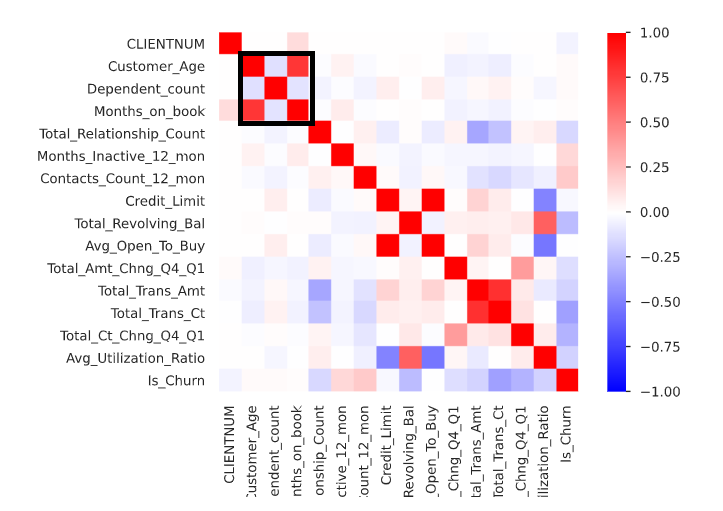

3. Credit limit has positive correlation with Avg open to buy
> Credit Limit = Total Revolving Balance + Avg Open to Buy (the amount left for buying things)

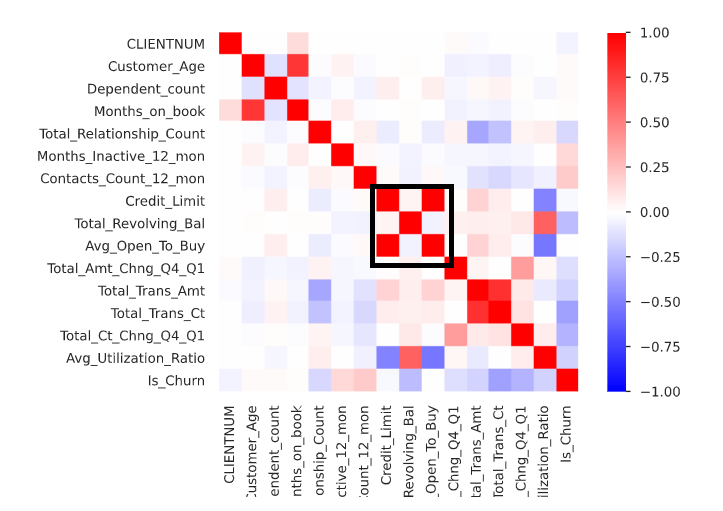

4. From Cramer's V for correlation of categorical data, we found high correlation between gender and income category
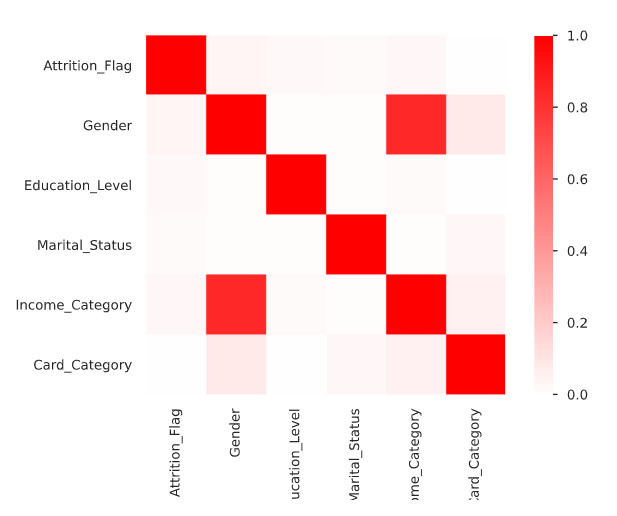

## Feature Engineering and Preprocessing

We are going to select only some features for the prediction
These features have to be normalized to before fitting the model
- Total relationship count (number of products held by customers)
- Months inactive within last 12 months / 12 (divided by number of months)
- Contact counts within last 12 months / 12 (divided by number of months)
- Total revolving balance / credit limit (to nomalize as porpotion of balance out of total credit limit)
- Total transaction count (nomalized by max value)
- Total transaction amount (nomalized by max value)
- Total changes in transaction count from Q4 to Q1
- Utilization ratio
- Income category (have to be preprocessed as it is categorical data)
- Edcuation level (have to be preprocessed as it is categorical data)
- Gender (have to be preprocessed as it is categorical data)

In [ ]:
data.columns

In [ ]:
# Numerical Data
data['Total_Relationship_Count'] = data['Total_Relationship_Count'] / data['Total_Relationship_Count'].max()
data['Months_Inactive_12_mon'] = data['Months_Inactive_12_mon'] / 12
data['Contacts_Count_12_mon'] = data['Contacts_Count_12_mon'] / 12
data['Revolving_Balance'] = data['Total_Revolving_Bal'] / data['Credit_Limit']
data['Total_Trans_Ct'] = data['Total_Trans_Ct'] / data['Total_Trans_Ct'].max()
data['Total_Trans_Amt'] = data['Total_Trans_Amt'] / data['Total_Trans_Amt'].max()


In [ ]:
numerical_columns = ['Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Revolving_Balance', 'Total_Trans_Ct', 'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Total_Ct_Chng_Q4_Q1']
categorical_columns = ['Income_Category', 'Education_Level', 'Gender']
label_column = ['Is_Churn']

In [ ]:
selected_data = data[numerical_columns + categorical_columns + label_column]

In [ ]:
# Categorical Data
# Convert these data to multipler columns
selected_data = pd.concat([selected_data, pd.get_dummies(selected_data['Income_Category'], prefix='Income'), pd.get_dummies(selected_data['Education_Level'], prefix='Education'), pd.get_dummies(selected_data['Gender'], prefix='Gender')], axis=1)
selected_data = selected_data.drop(categorical_columns, axis=1)

In [ ]:
# Features used in model training
selected_data.columns

## Train and Test Data Preparation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(selected_data.drop(label_column, axis=1), selected_data[label_column], test_size=0.2, random_state=123)

## Model Training using Gradient Boosted Classifier
Using grid search for finding optimal hyperparameters for GBClassifer

In [ ]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth":[3,5,10],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10, 50, 100]
    }

In [ ]:
# parameters = {
# #     "loss":["deviance"],
#     "learning_rate": [0.01, 0.1, 0.5],
# #     "min_samples_split": np.linspace(0.1, 0.5, 12),
# #     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,10],
# #     "max_features":["log2","sqrt"],
#     "subsample":[0.5, 0.8, 0.9, 1.0],
#     "n_estimators":[10, 50, 100]
#     }

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1, scoring='f1', verbose=2.5)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
# Get model with best hyperparameters
best_model = clf.best_estimator_
print("F1-score: ", clf.score(X_test, y_test))
print("Accuracy: ", accuracy_score(best_model.predict(X_test), y_test))
print("Best Model Param: ", clf.best_params_)

In [ ]:
# Find out what features the model depended on

feature_importances = dict(zip(X_train.columns.tolist(), best_model.feature_importances_))
feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: -item[1])}

plt.figure(figsize=(20, 15))G
# plt.rcParams.update({'font.size': 25})
plt.bar(range(len(feature_importances)), list(feature_importances.values()), align='center')
plt.xticks(range(len(feature_importances)), list(feature_importances.keys()), rotation='vertical')
plt.ylabel("Feature Importance")

In [ ]:
# Plot confusion matrix to find how the model performs
plot_confusion_matrix(best_model, X_test, y_test)

## Future Improvment
* Trim down the model to consider only important features
* Try more model variation to reduce false positive and false negative